In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("S06-hw-dataset-02.csv")

# Быстрый EDA
print(df.head())
print("\n Info")
print(df.info())
print("\n Target distribution")
print(df["target"].value_counts(normalize=True))

   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f34        f35    x_int_1    x

In [39]:
from sklearn.model_selection import train_test_split

# исключаем id и target
X = df.drop(columns=["id", "target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # сохраняем баланс классов
    random_state=42 # фиксируем для воспроизводимости
)

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

print("Dummy Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Dummy ROC-AUC:", roc_auc_score(y_test, y_proba_dummy))

Dummy Accuracy: 0.7375
Dummy ROC-AUC: 0.5


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

LR Accuracy: 0.8119444444444445
LR ROC-AUC: 0.7976914875596609


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# c контролем сложности
tree = DecisionTreeClassifier(random_state=42)
param_grid_tree = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [1, 2, 5, 10]
}

grid_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring="roc_auc")
grid_tree.fit(X_train, y_train)

best_tree = grid_tree.best_estimator_

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [1, 2, 5]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="roc_auc")
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

boost = HistGradientBoostingClassifier(random_state=42)
param_grid_boost = {
    "max_iter": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

grid_boost = GridSearchCV(boost, param_grid_boost, cv=5, scoring="roc_auc")
grid_boost.fit(X_train, y_train)

best_boost = grid_boost.best_estimator_

In [12]:
models = {
    "Dummy": dummy,
    "LogisticRegression": pipe_lr,
    "DecisionTree": best_tree,
    "RandomForest": best_rf,
    "HistGB": best_boost
}

results = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = None
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {"accuracy": acc, "f1": f1, "roc_auc": auc}
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

Dummy: Acc=0.7375, F1=0.0000, AUC=0.5000
LogisticRegression: Acc=0.8119, F1=0.5607, AUC=0.7977
DecisionTree: Acc=0.8383, F1=0.6576, AUC=0.8371
RandomForest: Acc=0.8908, F1=0.7579, AUC=0.9281
HistGB: Acc=0.9033, F1=0.7984, AUC=0.9296


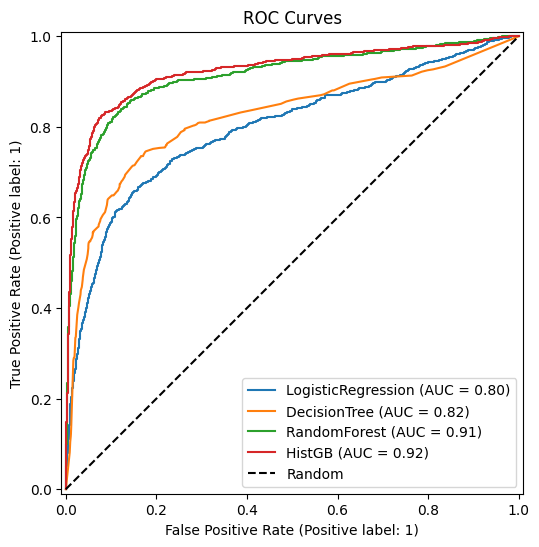

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import os

# получаем абсолютный путь к текущему ноутбуку
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# формируем путь к папке figures
figures_dir = os.path.join(notebook_dir, "artifacts", "figures")

# убедимся, что папка существует
os.makedirs(figures_dir, exist_ok=True)

plt.figure(figsize=(8, 6))
for name, model_tuple in models.items():
    if name == "Dummy": continue
    # model_tuple[0] - это сам объект модели
    RocCurveDisplay.from_estimator(model_tuple[0], X_test, y_test, name=name, ax=plt.gca())
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend()
plt.title("ROC Curves")

# Сохраняем
plt.savefig(os.path.join(figures_dir, "roc_curve.png"), dpi=150, bbox_inches='tight')
plt.show()

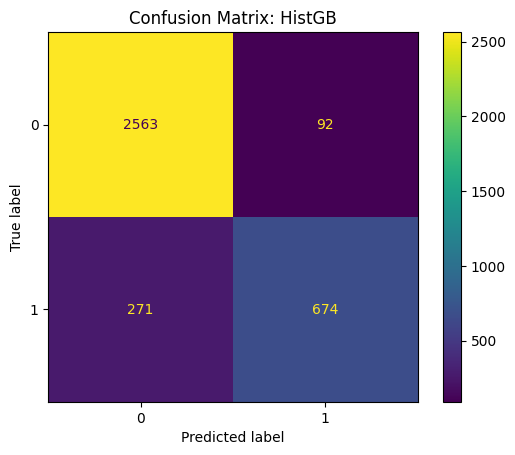

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

# получаем абсолютный путь к ноутбуку
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
figures_dir = os.path.join(notebook_dir, "artifacts", "figures")
os.makedirs(figures_dir, exist_ok=True)

best_model_name = max(results, key=lambda k: results[k]["roc_auc"])
best_model_tuple = models[best_model_name]  # это кортеж (модель, proba)
best_model = best_model_tuple[0]  # берём только сам объект модели

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Confusion Matrix: {best_model_name}")
plt.savefig(os.path.join(figures_dir, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
plt.show()

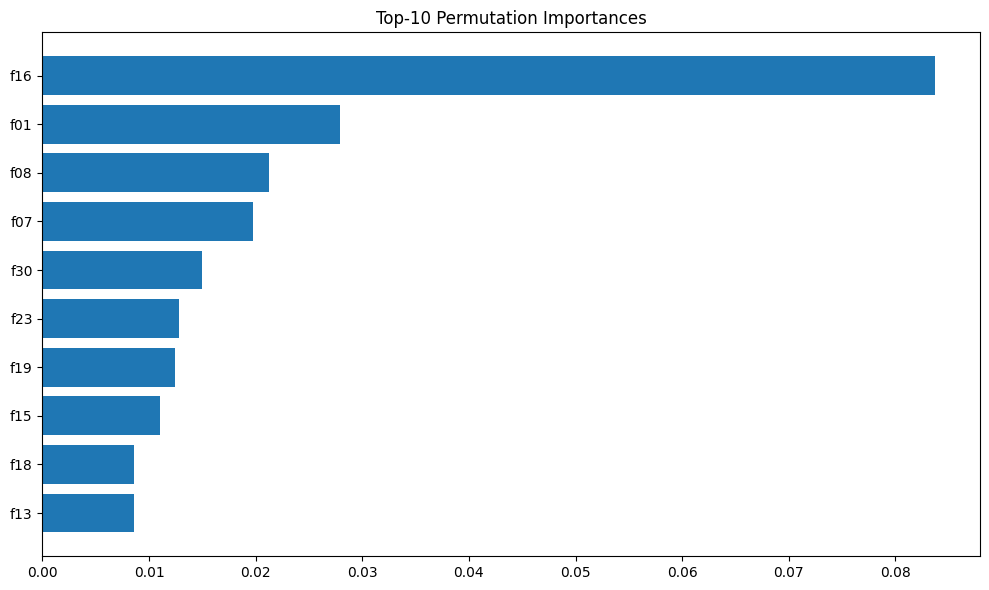

In [44]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
figures_dir = os.path.join(notebook_dir, "artifacts", "figures")
os.makedirs(figures_dir, exist_ok=True)

best_model_name = max(results, key=lambda k: results[k]["roc_auc"])
best_model_tuple = models[best_model_name]
best_model = best_model_tuple[0]

perm_imp = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

indices = np.argsort(perm_imp.importances_mean)[::-1][:10]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), perm_imp.importances_mean[indices])
plt.yticks(range(len(indices)), feature_names)
plt.gca().invert_yaxis()
plt.title("Top-10 Permutation Importances")
plt.tight_layout()

plt.savefig(os.path.join(figures_dir, "permutation_importance.png"), dpi=150, bbox_inches='tight')
plt.show()

In [47]:
import json
import joblib
import os

# создаём директории, если их нет
os.makedirs("homeworks/HW06/artifacts/figures", exist_ok=True)
os.makedirs("homeworks/HW06/artifacts", exist_ok=True)

# метрики всех моделей на test
with open("homeworks/HW06/artifacts/metrics_test.json", "w") as f:
    json.dump(results, f, indent=2)

# лучшая модель
joblib.dump(best_model, "homeworks/HW06/artifacts/best_model.joblib")

# метаданные лучшей модели
meta = {
    "best_model": best_model_name,
    "metrics": results[best_model_name],
    "random_state": 42,
    "test_size": 0.2
}
with open("homeworks/HW06/artifacts/best_model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# параметры из GridSearchCV
search_summaries = {}
if 'grid_tree' in locals():
    search_summaries["DecisionTree"] = grid_tree.best_params_
if 'grid_rf' in locals():
    search_summaries["RandomForest"] = grid_rf.best_params_
if 'grid_boost' in locals():
    search_summaries["HistGB"] = grid_boost.best_params_

with open("homeworks/HW06/artifacts/search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=2)